In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [2]:
# Import Dataset
df = pd.read_excel(r"C:\Users\dell\Desktop\assignment\CocaCola_Sales_Rawdata.xlsx")

In [3]:
df

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [4]:
df.isnull().any()

Quarter    False
Sales      False
dtype: bool

In [5]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

###  Descriptive Analysis

In [6]:
df.shape

(42, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [8]:
#Unique values for every feature
df.nunique()

Quarter    42
Sales      42
dtype: int64

In [9]:
df[df.duplicated()].shape

(0, 2)

In [10]:
df[df.duplicated()]

,Quarter,Sales


In [11]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


### Feature Engineering

#### Converting the Quarters into Years

In [12]:
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#Clean way to convert quarterly periods to datetime in pandas
df.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


#### Coverting Quarter Years with Quarter Start Date Year (Date Month and Year)

In [13]:
# converting into datetime formate as the index was not in correct formate.
df['Date'] = (
    pd.to_datetime(
        df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
,dayfirst=True))
df.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


### Extracting the Quarters and putting in column

In [14]:
df['Quarters'] = 0

for i in range(42):
    n = df['Quarter'][i]
    df['Quarters'][i] = n[0:2]
    
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2


### Creating Dummy Variables for Quarters Variable

In [15]:
dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df, dummy), axis=1)

df1.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


### Dropping all the unnecessary column

In [16]:
df1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
df1.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


#### Making the Date as DateTime index for the Dataframe

In [17]:
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [18]:
df1.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


#### Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data

In [19]:
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,Apr,1987
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,Jul,1987
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,Oct,1987
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,Jan,1988
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,Apr,1988


### Data Visualization

<AxesSubplot:xlabel='month', ylabel='year'>

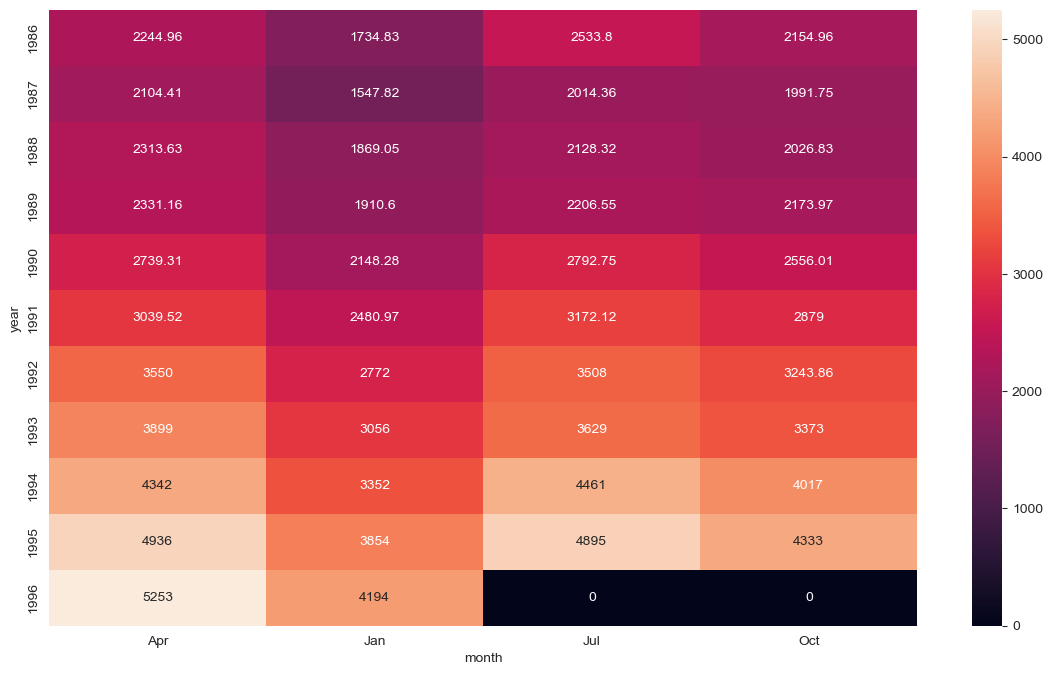

In [20]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=df,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values

### line plot

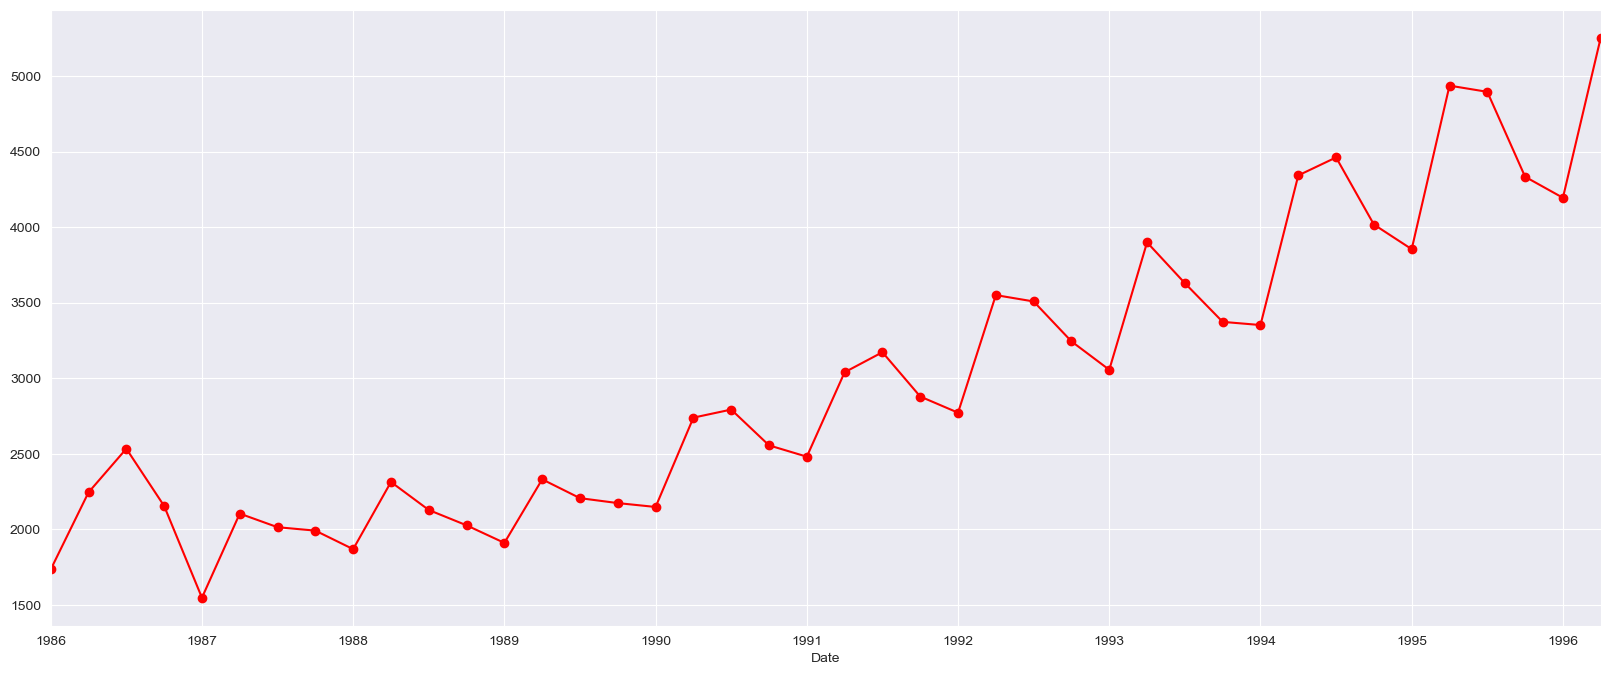

In [21]:
df1['Sales'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

### Line Plot Using Quarters as Y axis and Sales as X axis

<AxesSubplot:xlabel='Quarters', ylabel='Sales'>

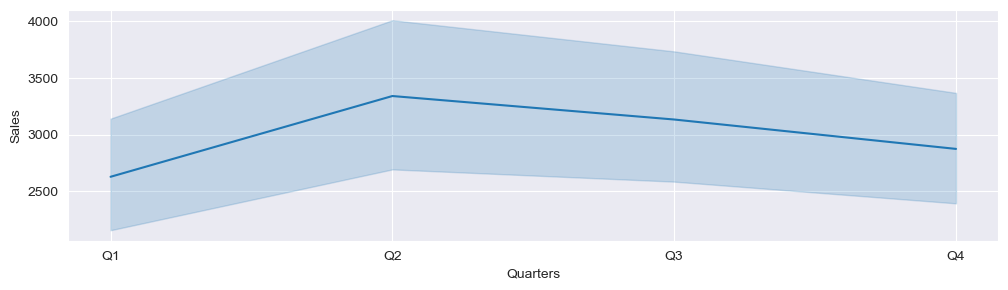

In [22]:
plt.figure(figsize=(12,3))
sns.lineplot(x="Quarters", y="Sales", data=df)

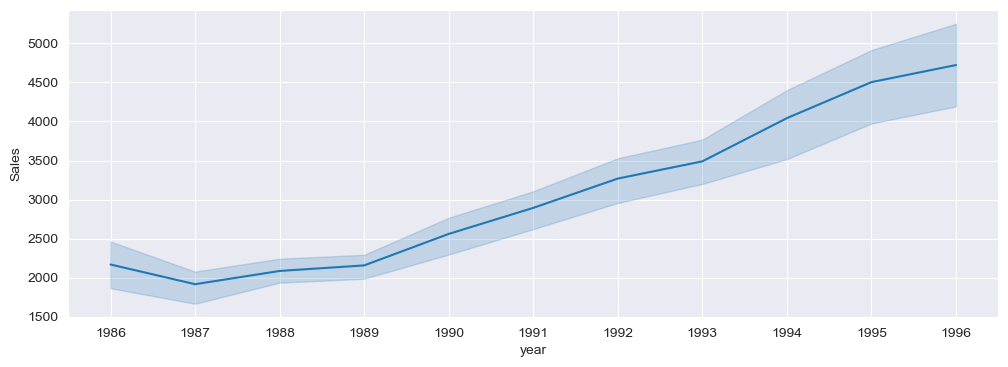

In [23]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

### Box Plot of Each Year by Quaterly Intervals

<AxesSubplot:xlabel='year', ylabel='Sales'>

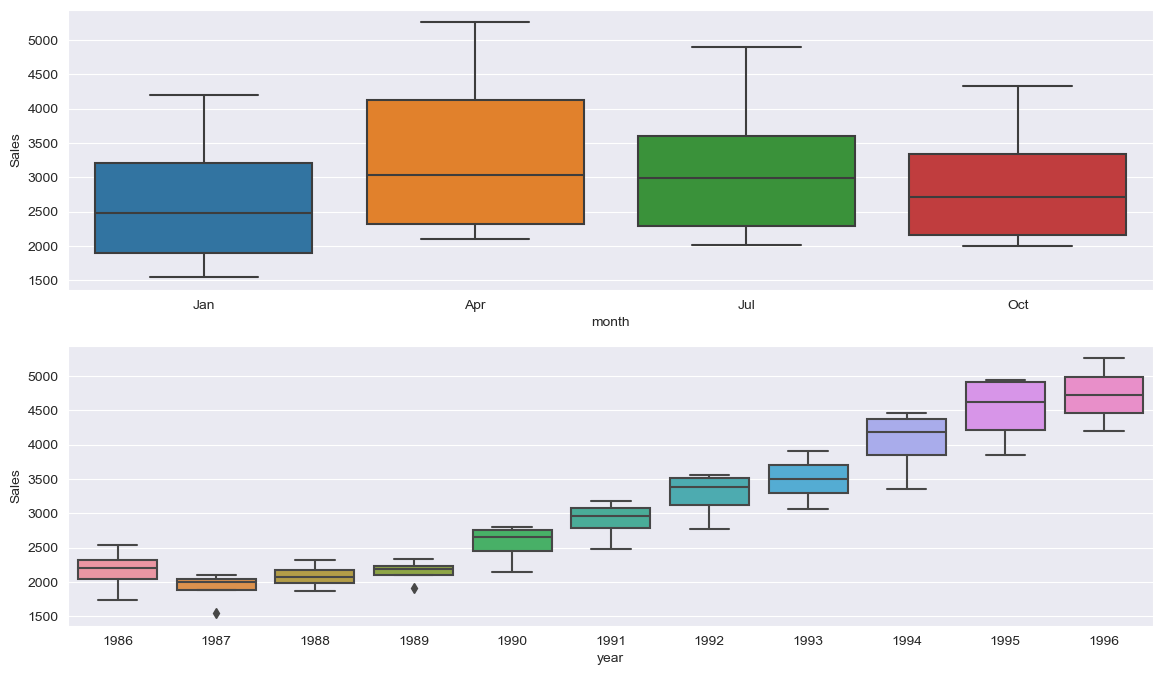

In [24]:
# Boxplot for ever
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=df)

### Histogram and Density Plots

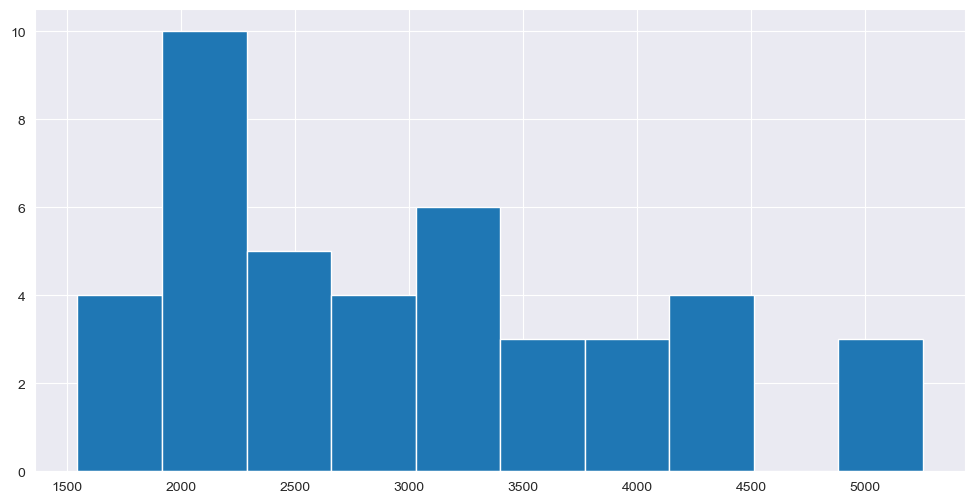

In [25]:
df.Sales.hist(figsize=(12,6))
plt.show()

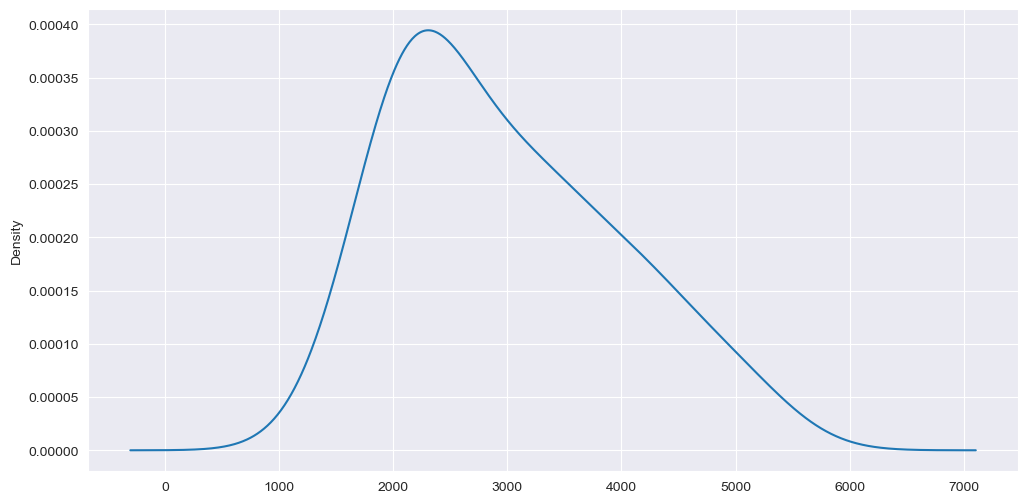

In [26]:
# create a density plot
df.Sales.plot(kind='kde', figsize=(12,6))
plt.show()

### lag plot

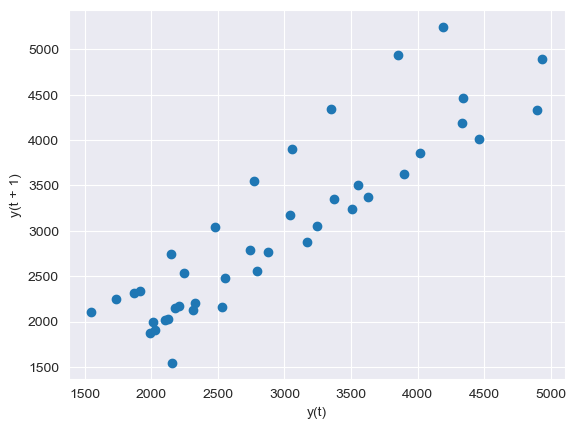

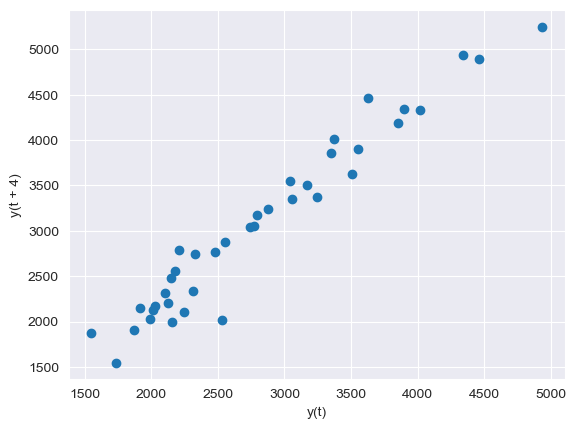

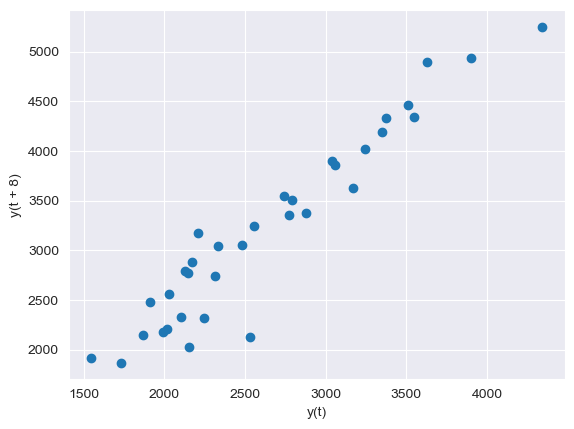

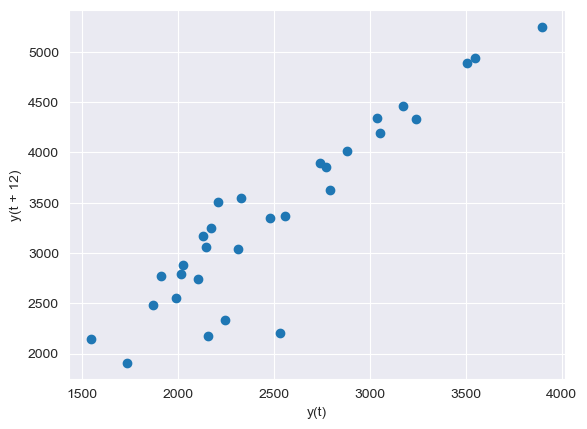

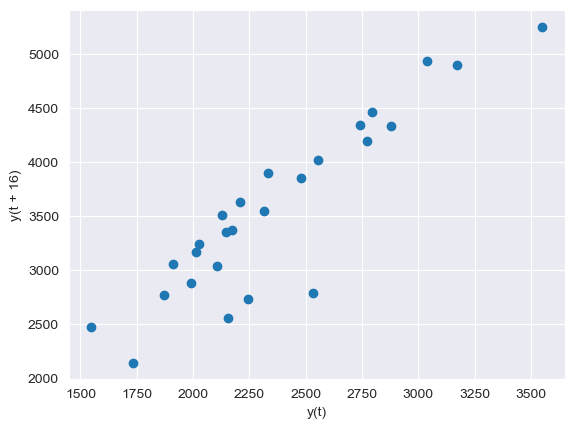

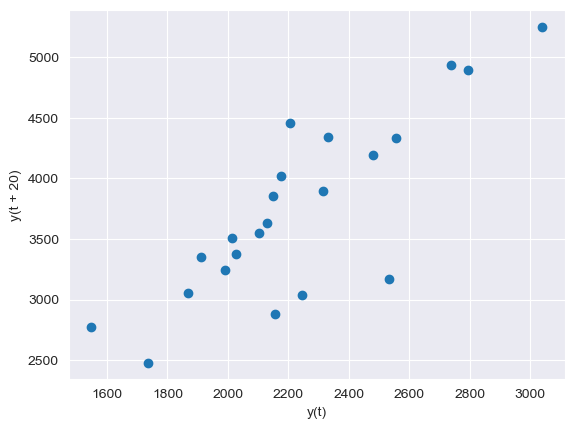

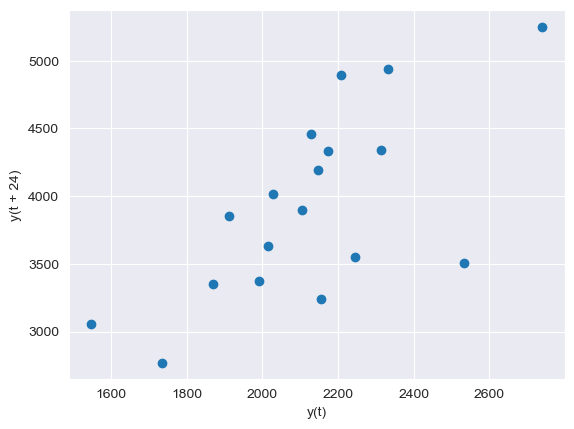

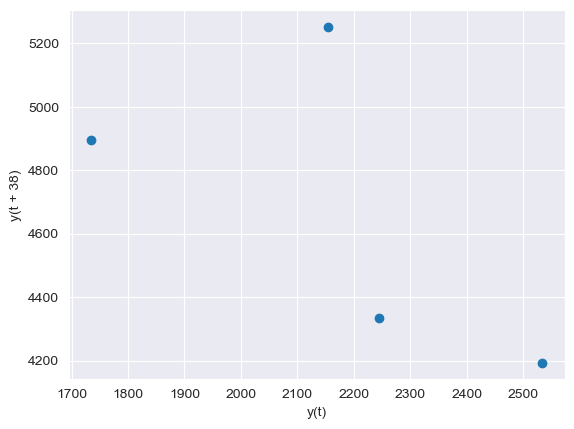

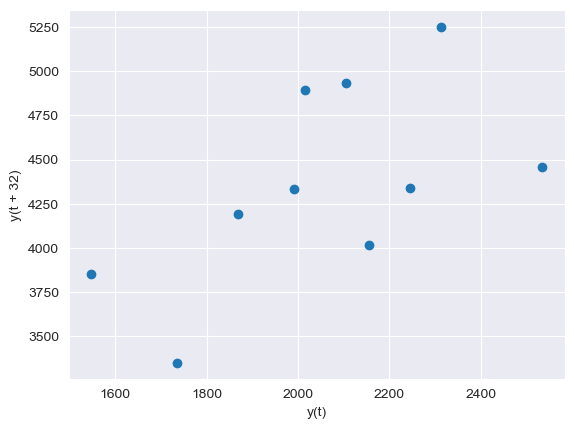

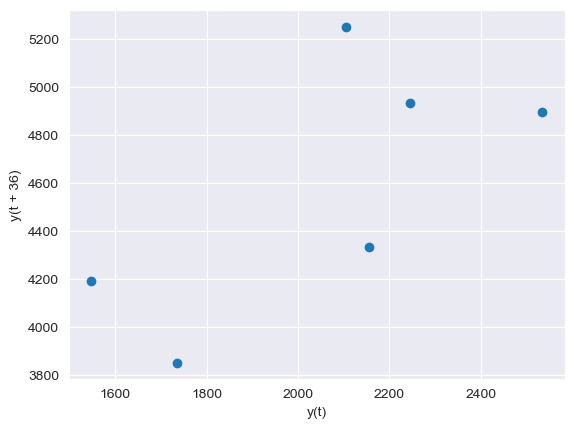

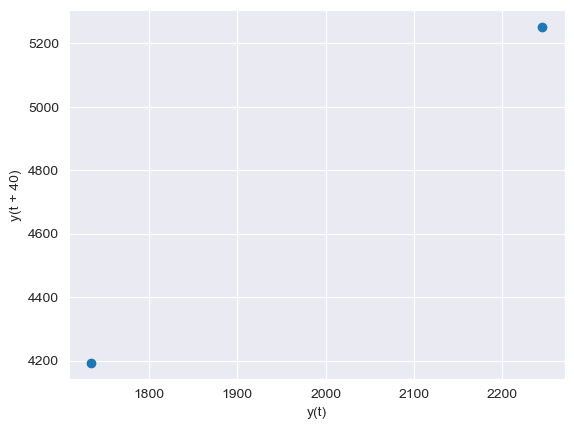

In [27]:
# create scatter plot
for i in [1,4,8,12,16,20,24,38,32,36,40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Sales,lag=i)
    plt.show()

#### Moving Average

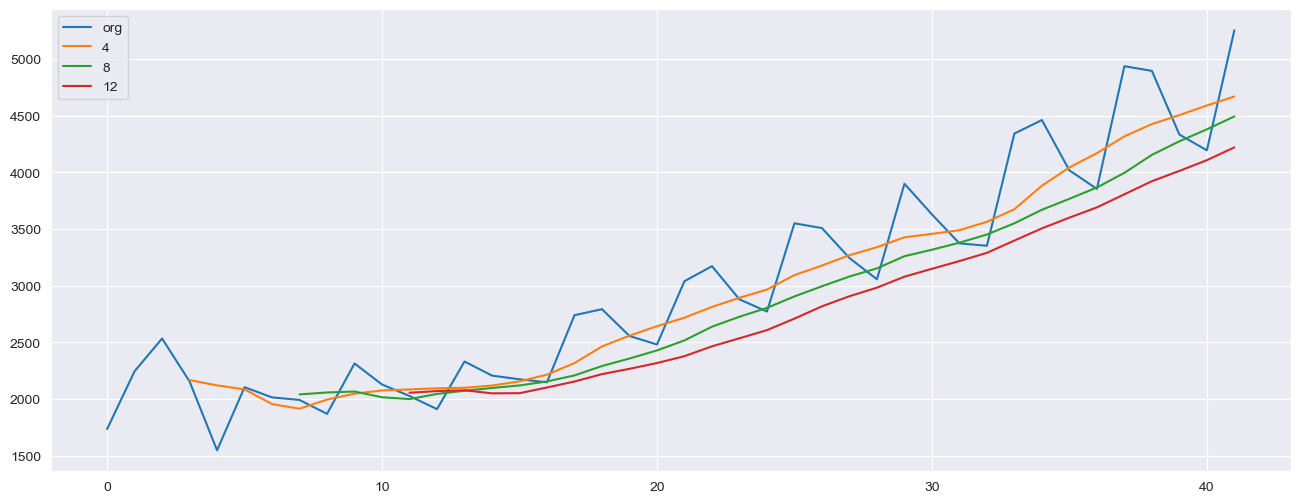

In [28]:
plt.figure(figsize=(16,6))
df.Sales.plot(label="org")
for i in range(4,13,4):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

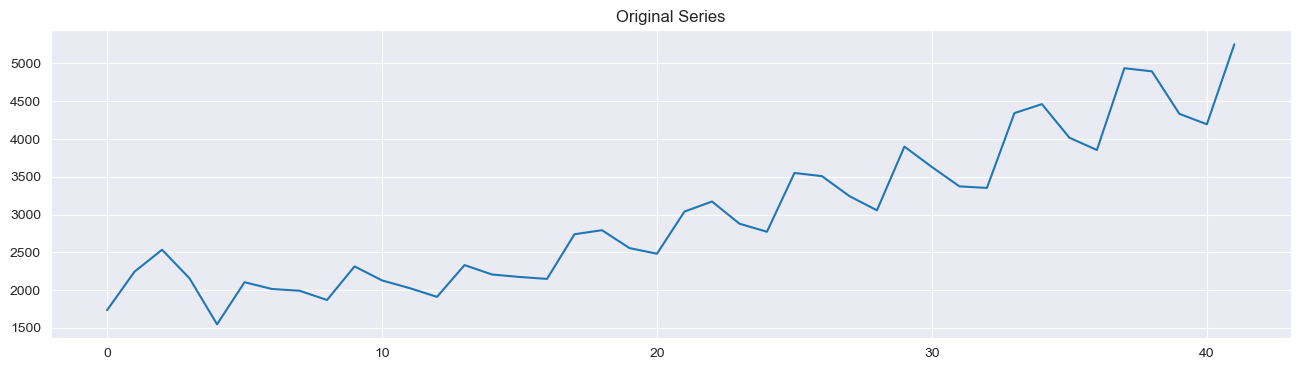

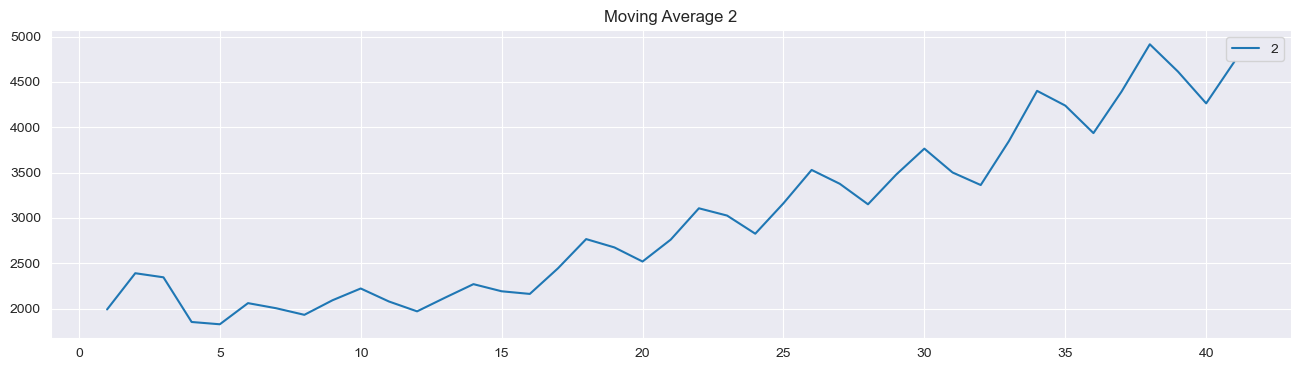

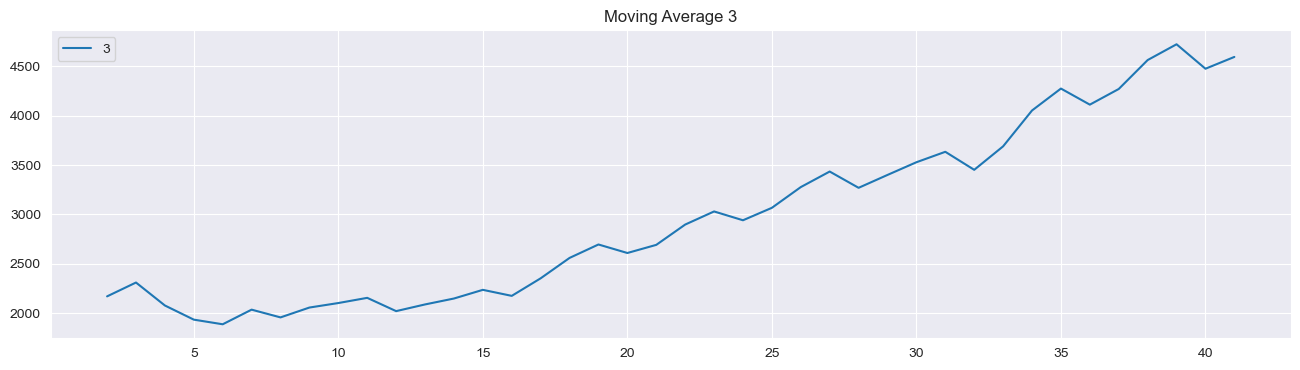

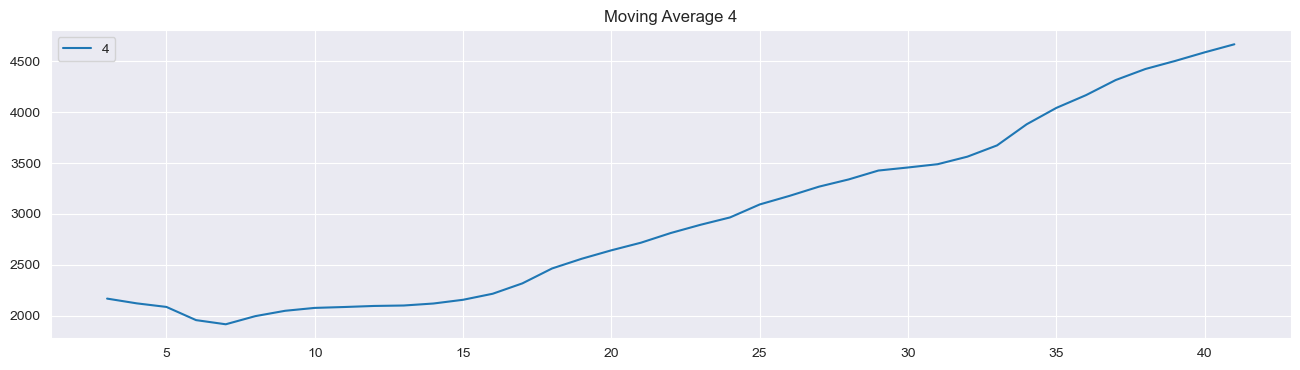

In [29]:
plt.figure(figsize=(16,4))
df.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,5):
    plt.figure(figsize=(16,4))
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

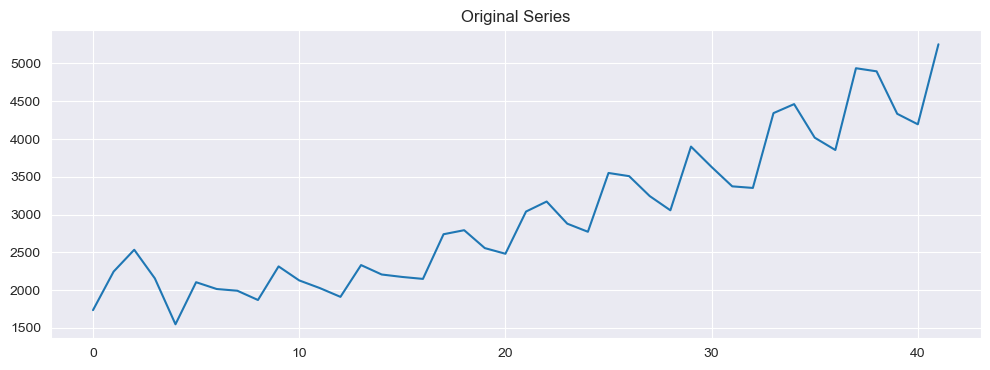

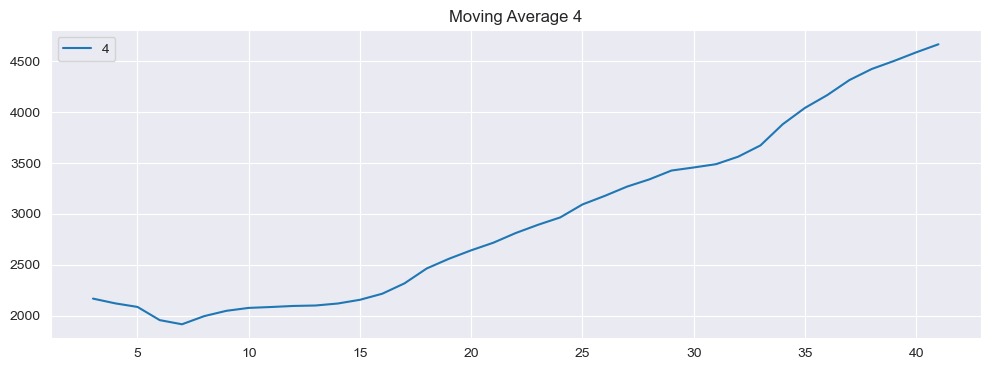

In [30]:
plt.figure(figsize=(12,4))
df.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
df["Sales"].rolling(4).mean().plot(label=str(4))
plt.title("Moving Average "+str(4))
plt.legend(loc='best')
plt.show()

### Time series Decomposition plot

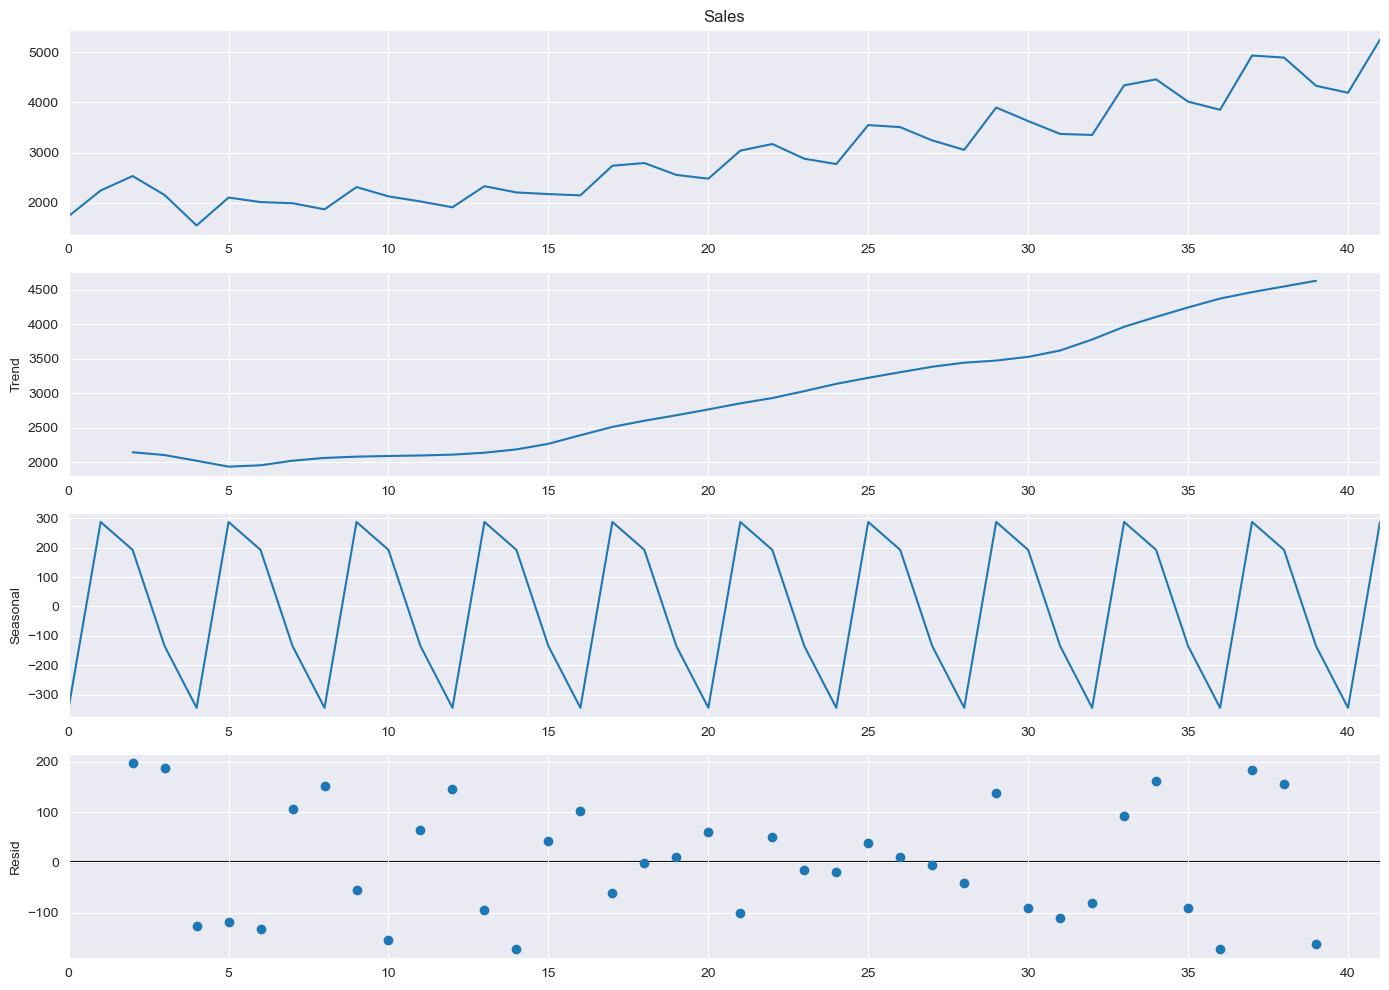

In [31]:
decompose_ts_add = seasonal_decompose(df.Sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

### ACF plots and PACF plots¶

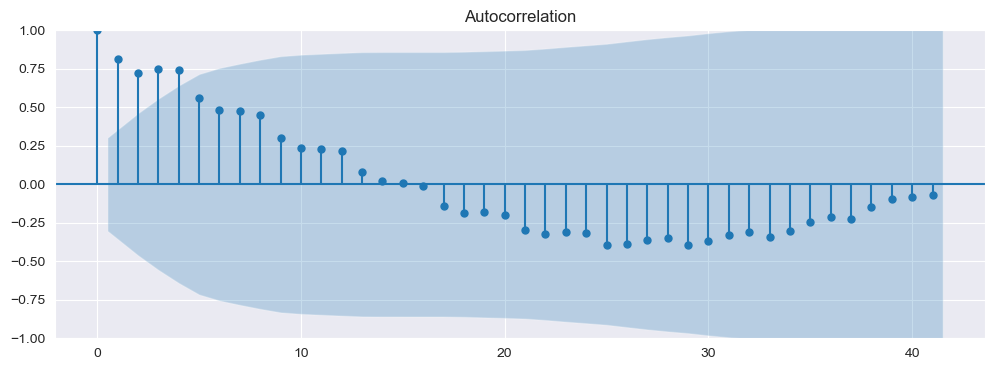

In [32]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Sales,lags=41)
    plt.show()

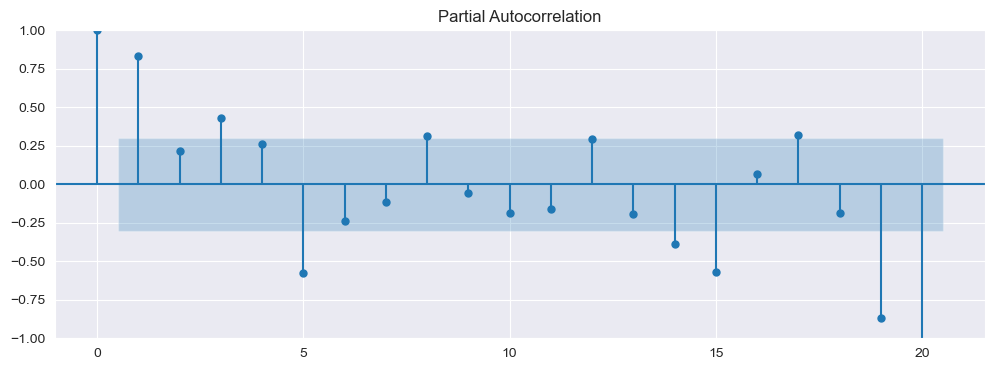

In [34]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc('figure',figsize=(12,4))
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

### To summarize, a partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.

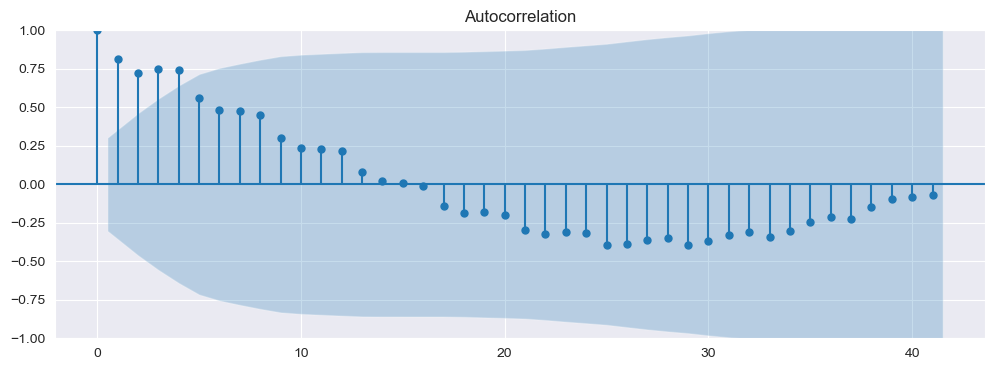

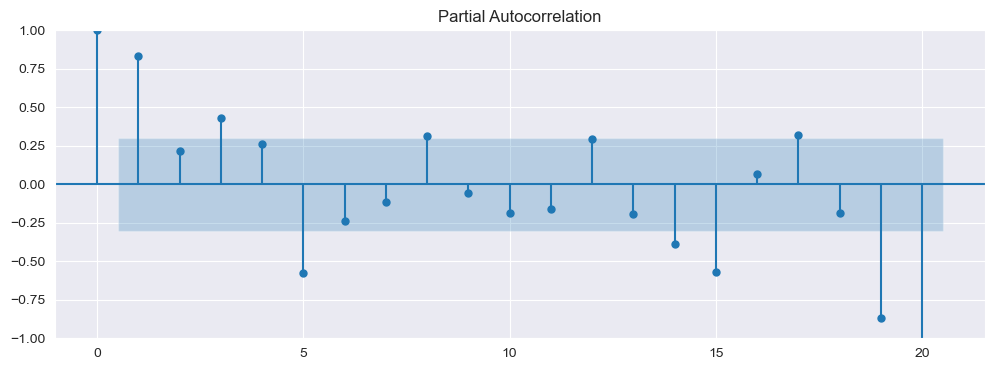

In [36]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc('figure',figsize=(12,4))
    tsa_plots.plot_acf(df.Sales,lags=41)
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

### Sampling

### Linear interpolation

### upsampling with respect to month

In [37]:
upsampled_month = df1.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996
1987-02-28  1733.349996
1987-03-31  1918.880995


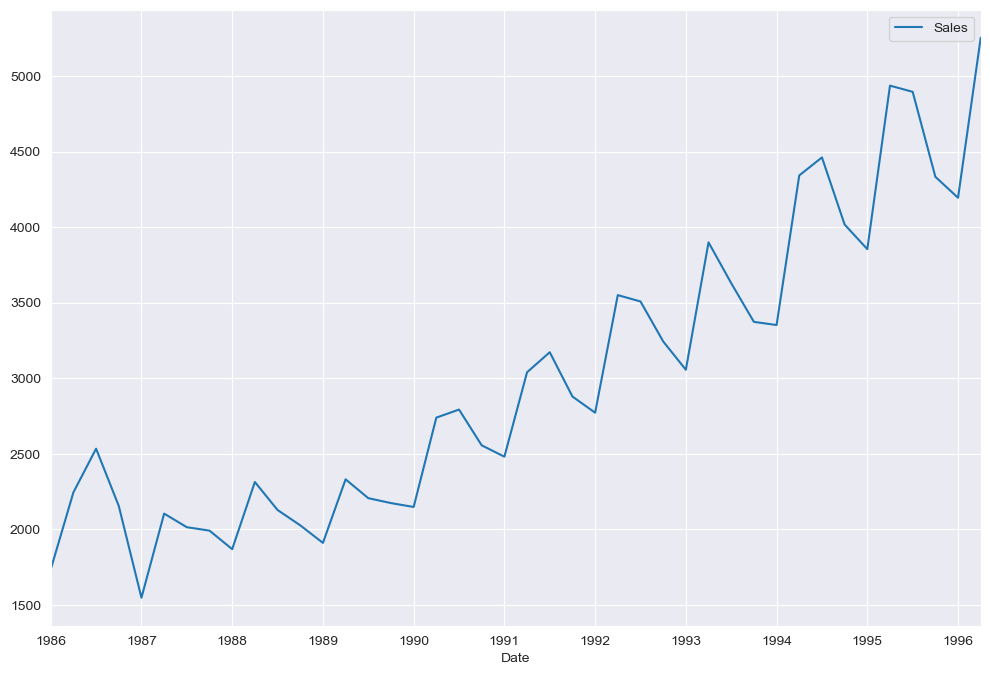

In [38]:
interpolated_month = upsampled_month.interpolate(method='linear') ## interplation was done for nan values which we get after doing upsampling by month
print(interpolated_month.head(15))
interpolated_month.plot(figsize=(12,8))
plt.show()

In [39]:
interpolated_month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


In [40]:
visual = interpolated_month.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual[:2]


,Sales,date,year,month,week,quarter,day_of_week
0,1734.827000,1986-01-31,1986,1,5,1,Friday
1,1904.871666,1986-02-28,1986,2,9,1,Friday


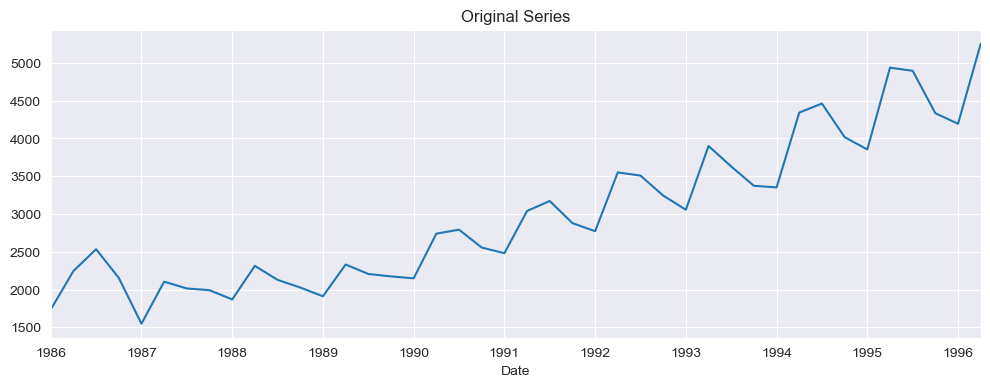

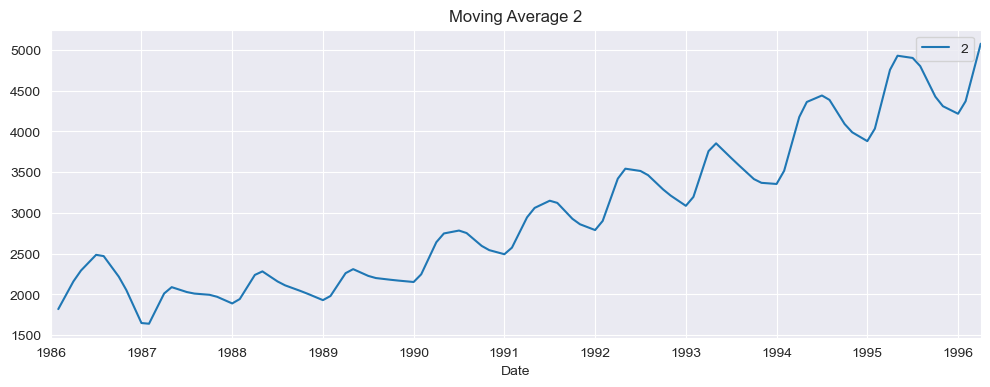

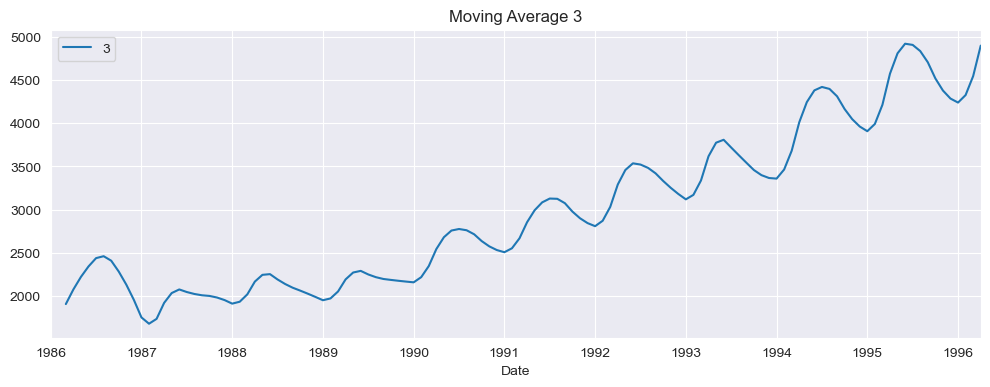

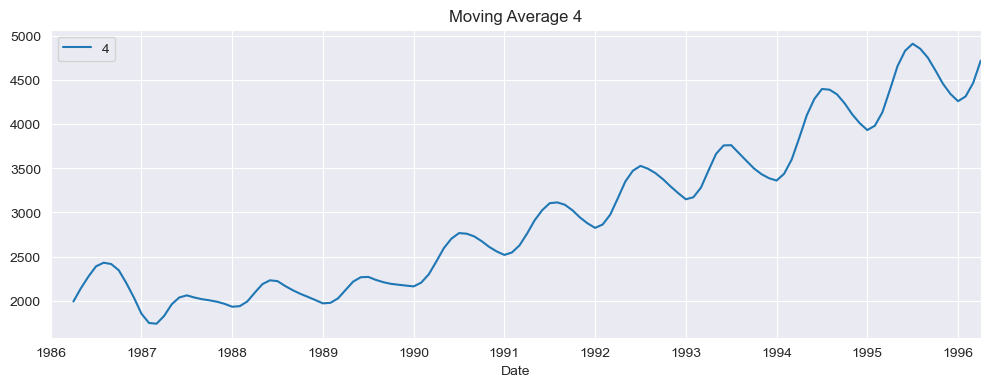

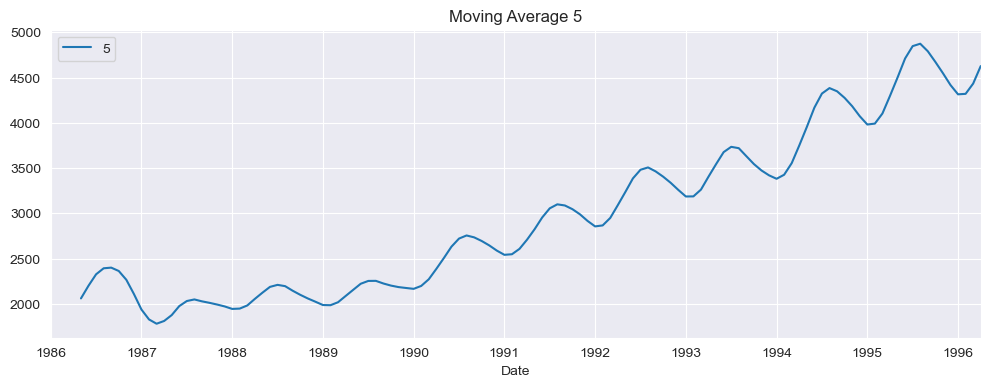

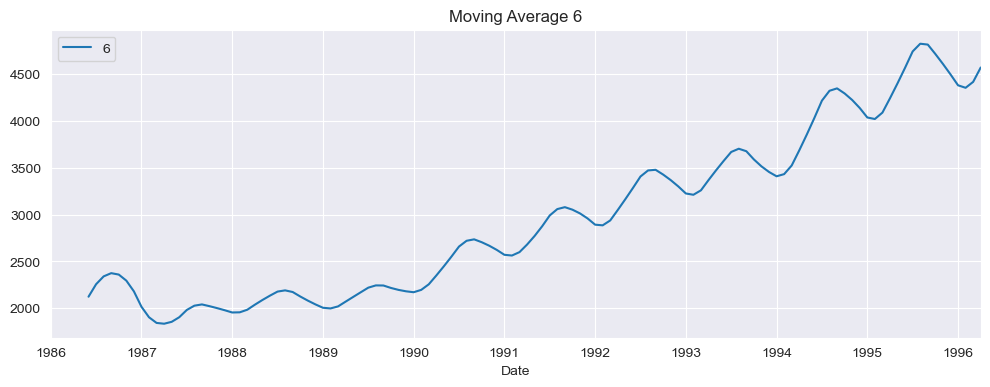

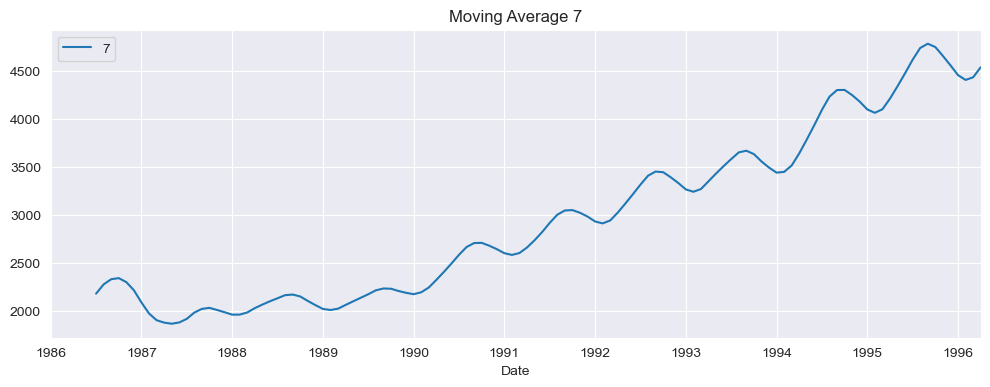

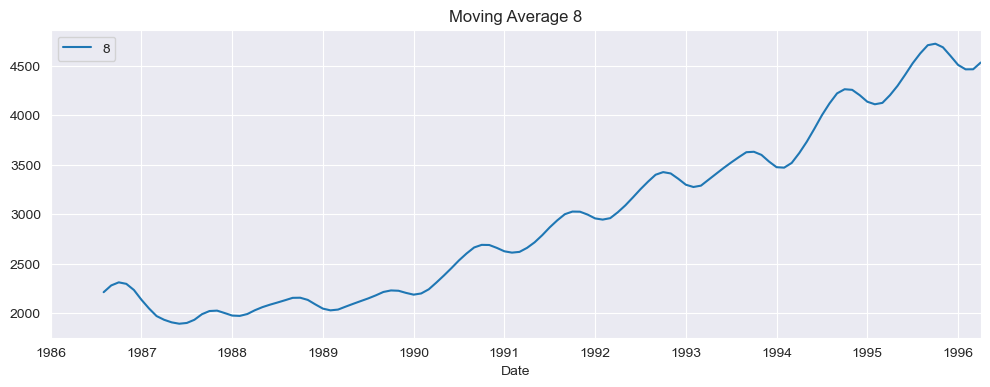

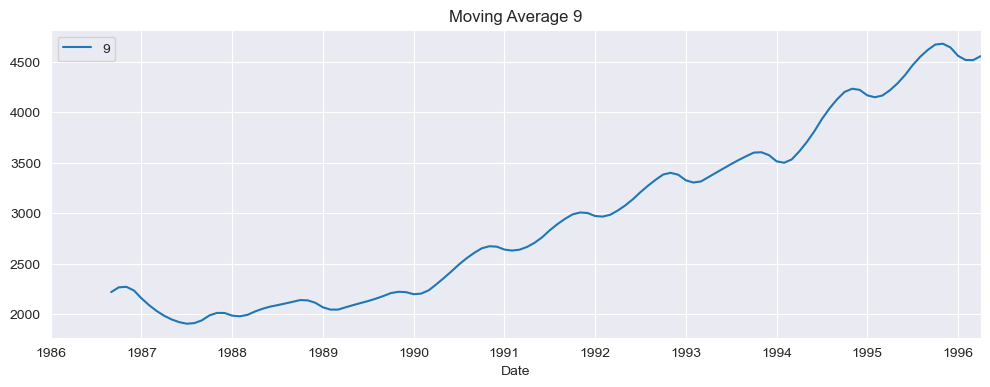

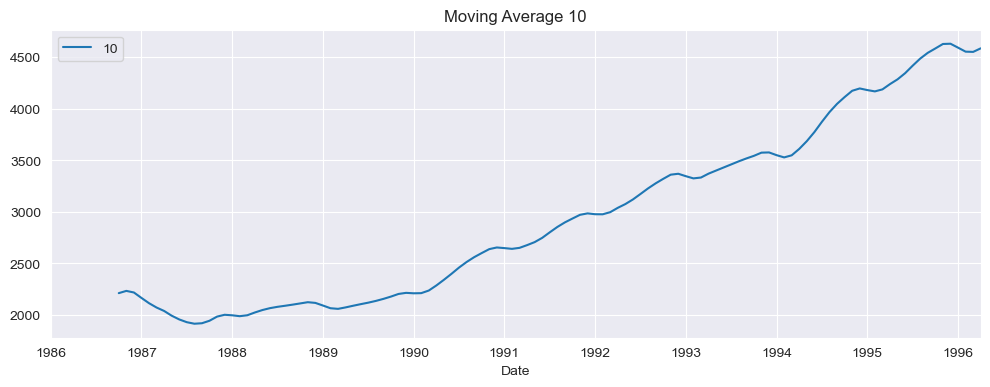

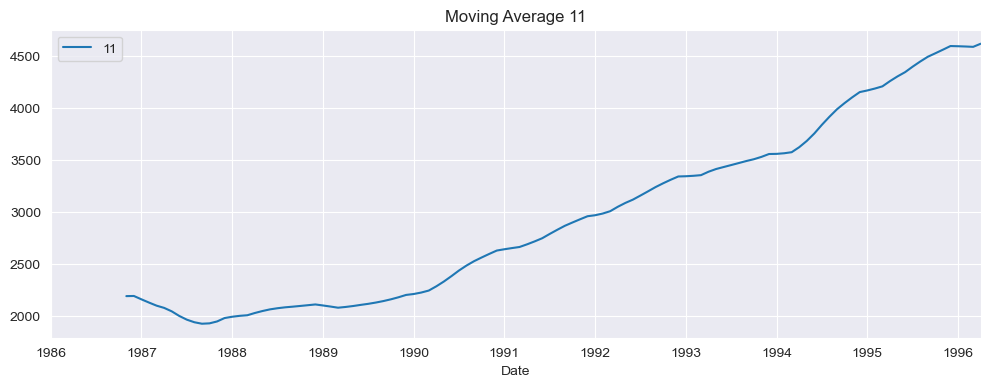

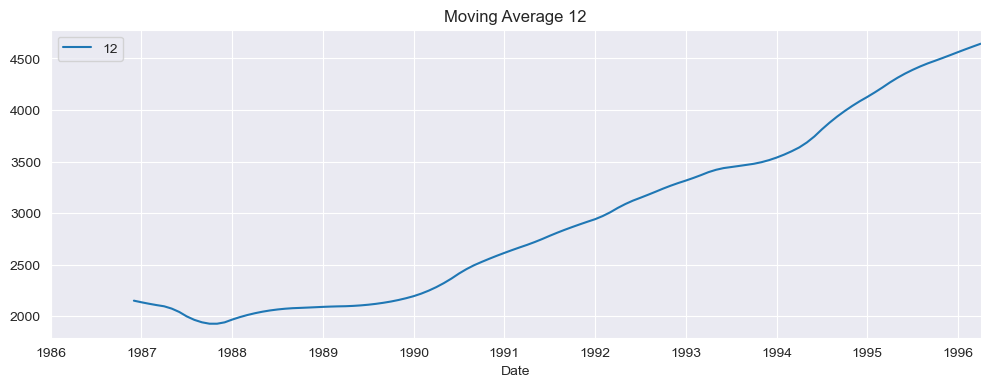

In [41]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(12,4))
    interpolated_month["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

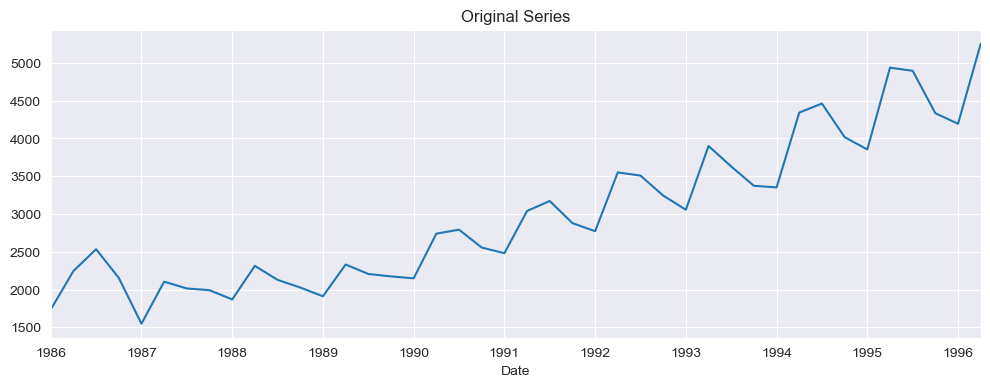

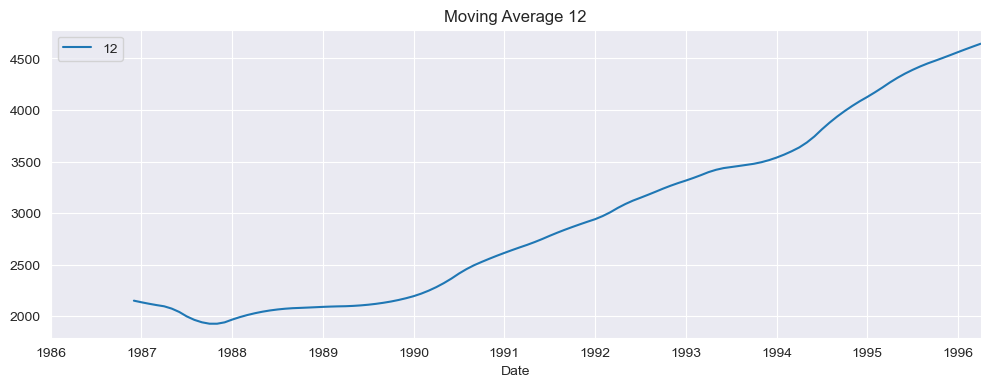

In [42]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
interpolated_month["Sales"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

### Additive Seasonal Decomposition

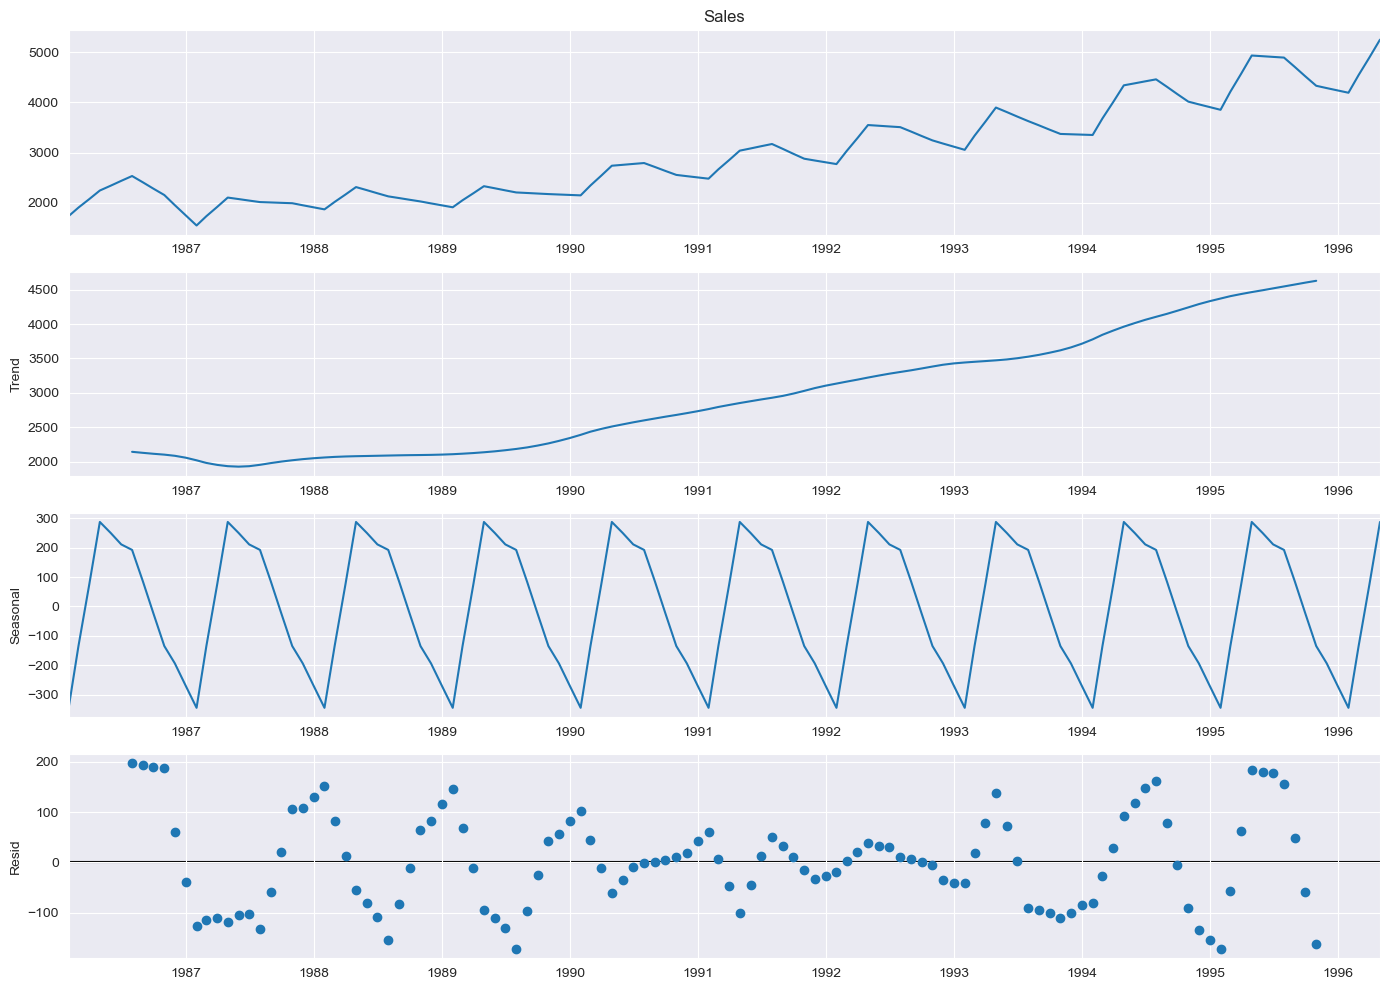

In [43]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

#### Multiplicative Seasonal Decomposition

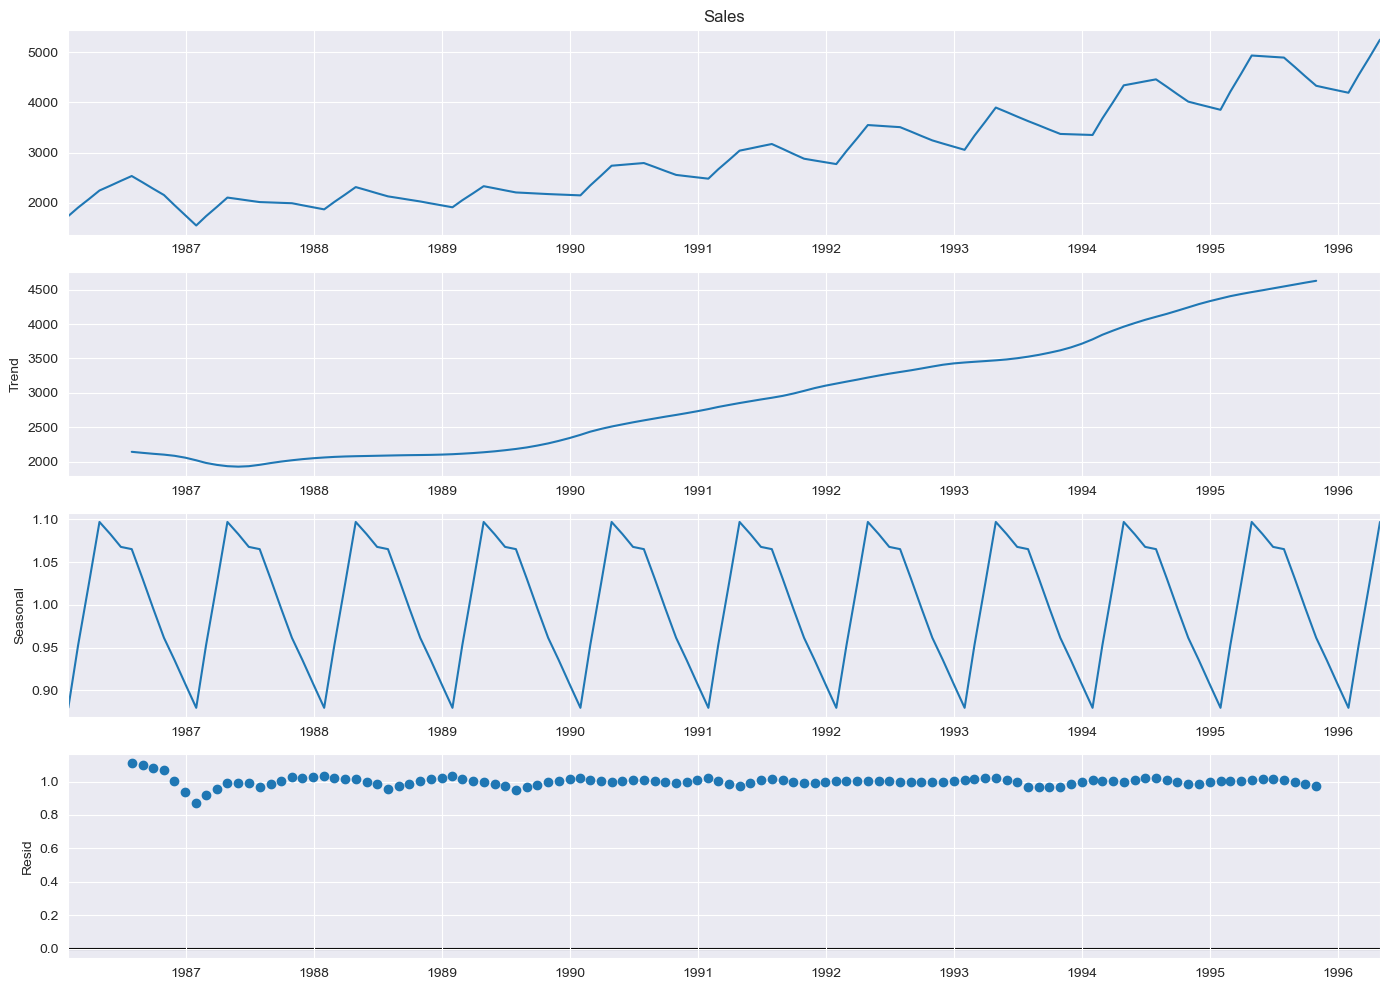

In [44]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

### Splitting Train and Test Data

##### Leaving Test Data with 2 Years of Time Series

In [45]:
train_data = interpolated_month[:100]
test_data = interpolated_month[100:]

In [46]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test: 1994-05-31 00:00:00 1996-04-30 00:00:00


<AxesSubplot:xlabel='Date'>

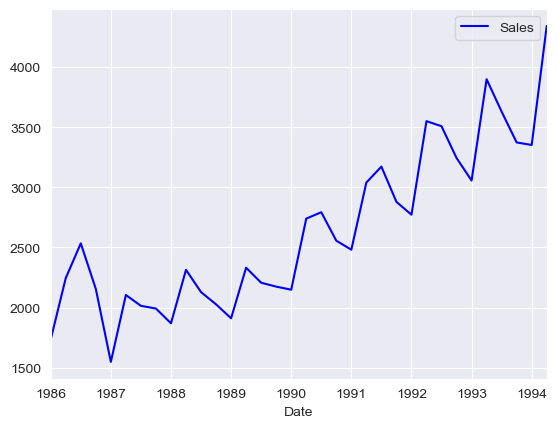

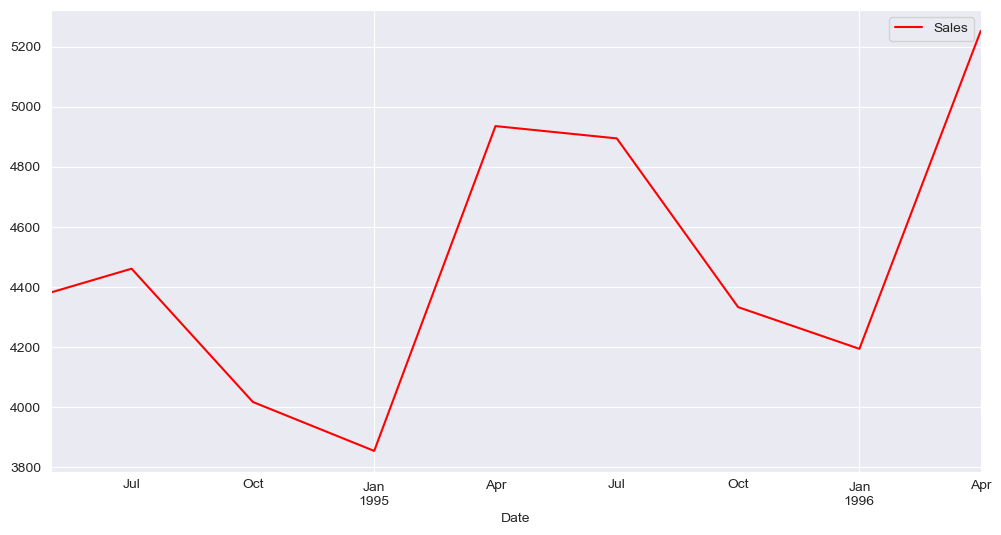

In [47]:
train_data.plot(legend=True,label='TRAIN',color='blue')
test_data.plot(legend=True,label='TEST', figsize=(12,6),color='red')

### Evaluation Metric MAPE

In [48]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

### Exponential Methods¶

### Simple Exponential Method

#### Using Forecast Attribute

In [49]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.619719427225402 
 Train Root Mean Squared Error = 129.37951453141417 
 Test Root Mean Squared Error = 381.95422355078995


#### Using Predict Attribute

In [50]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.predict(start = test_data.index[0],end = test_data.index[-1])
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.619719427225402 
 Train Root Mean Squared Error = 129.37951453141417 
 Test Root Mean Squared Error = 381.95422355078995


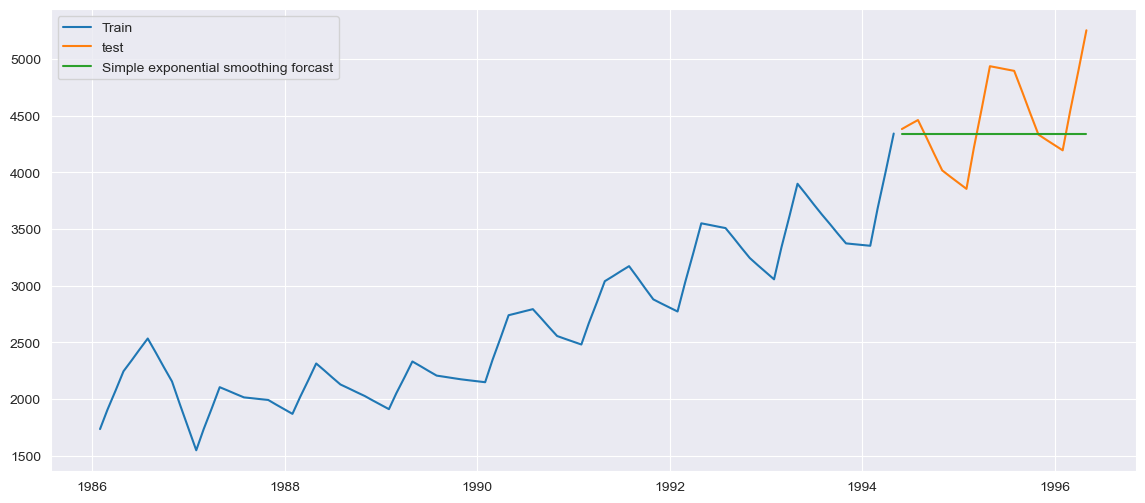

In [51]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

### Holt method (Double Exponential)

In [52]:
#### Captures both Level and Trend .

In [53]:
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Sales))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 89.7001615463704 
 Train Root Mean Squared Error = 108.58347720512378 
 Test Root Mean Squared Error = 4560.457728458048


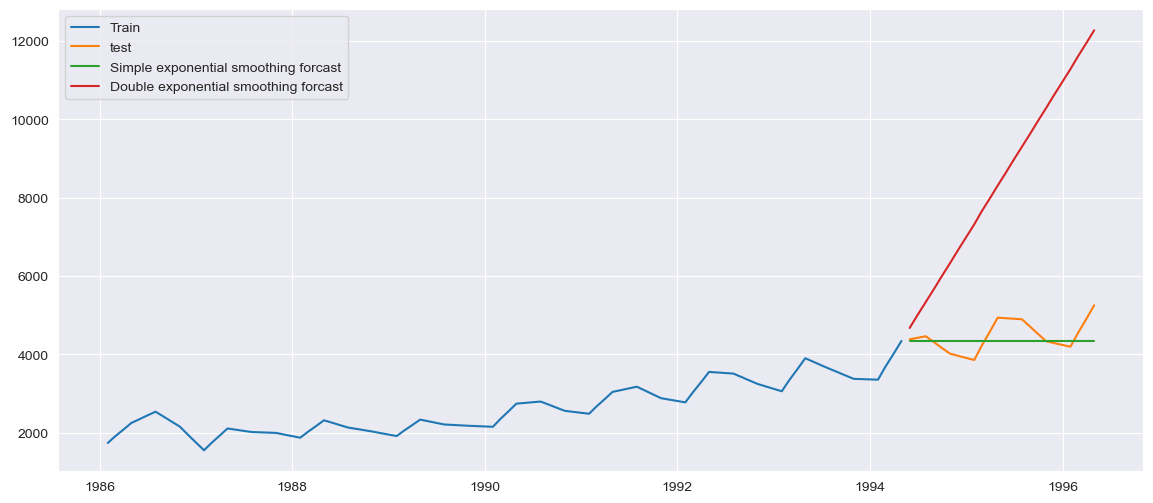

In [54]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

### Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

In [55]:
### Captures Level, Trend and Seasonality.

In [56]:
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Sales))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Sales)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 34.23944156457067 
 Train Root Mean Squared Error = 44.17572264662261 
 Test Root Mean Squared Error = 1758.7055544098644


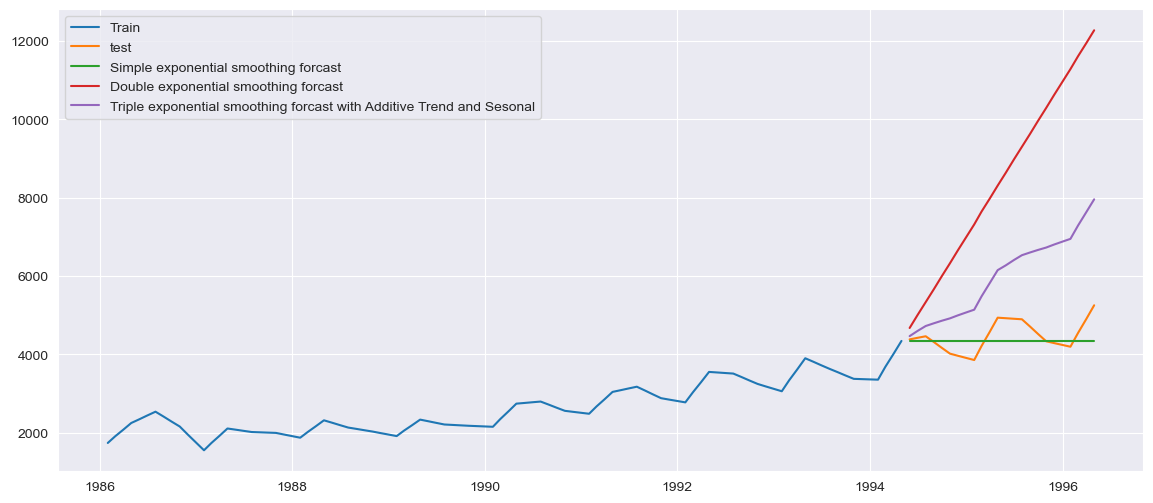

In [57]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

### Autoregressive Integrated Moving Averages (ARIMA)

#### Test of Stationarity

In [60]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

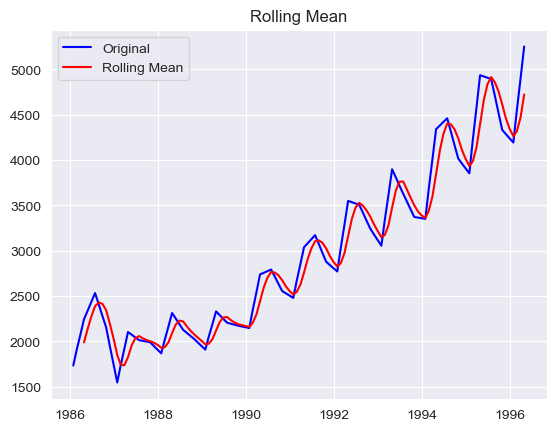

Results of Dickey Fuller Test:
Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [61]:
sales= pd.DataFrame()
sales['Sales'] = interpolated_month[['Sales']]
test_stationarity(sales)

In [62]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [63]:
adf_test(sales.Sales)

Fail to reject the null hypothesis
Data is non-stationary


### Feature Scaling (Transformations)

#### Square root transformation

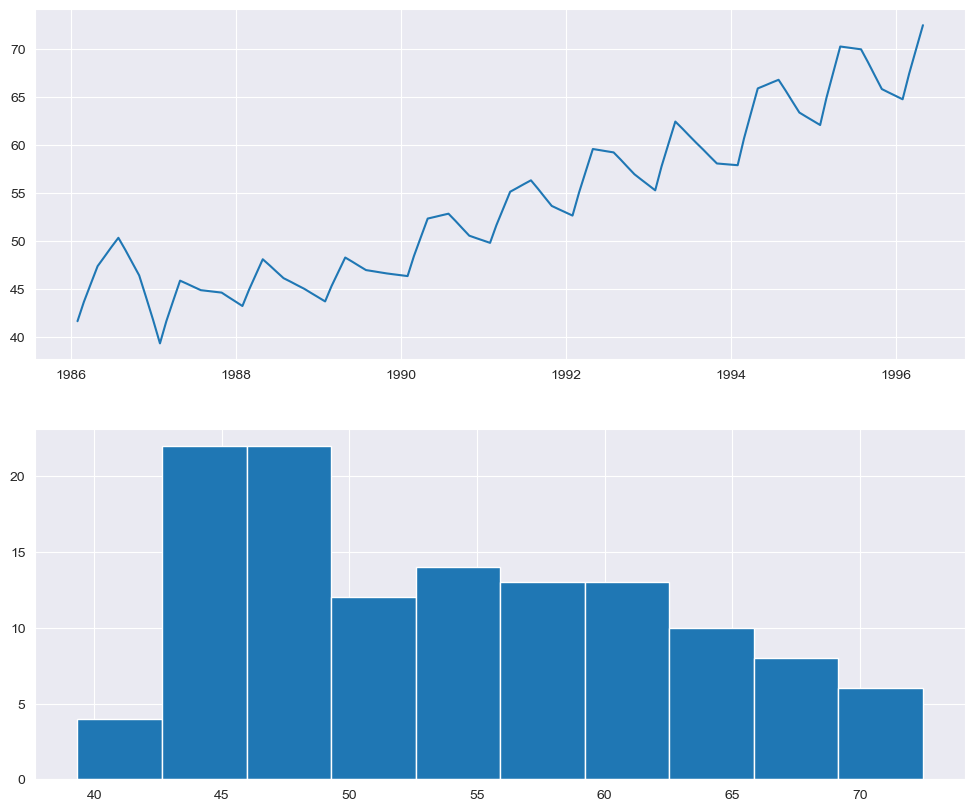

In [64]:
square_root= pd.DataFrame()
square_root = interpolated_month[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Sales'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Sales'])
plt.show()


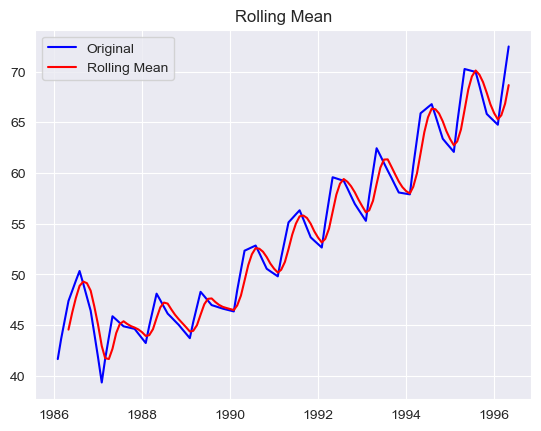

Results of Dickey Fuller Test:
Test Statistic                   0.728012
p-value                          0.990381
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [65]:
test_stationarity(square_root)

In [66]:
adf_test(square_root.Sales)

Fail to reject the null hypothesis
Data is non-stationary


####  Log Transform

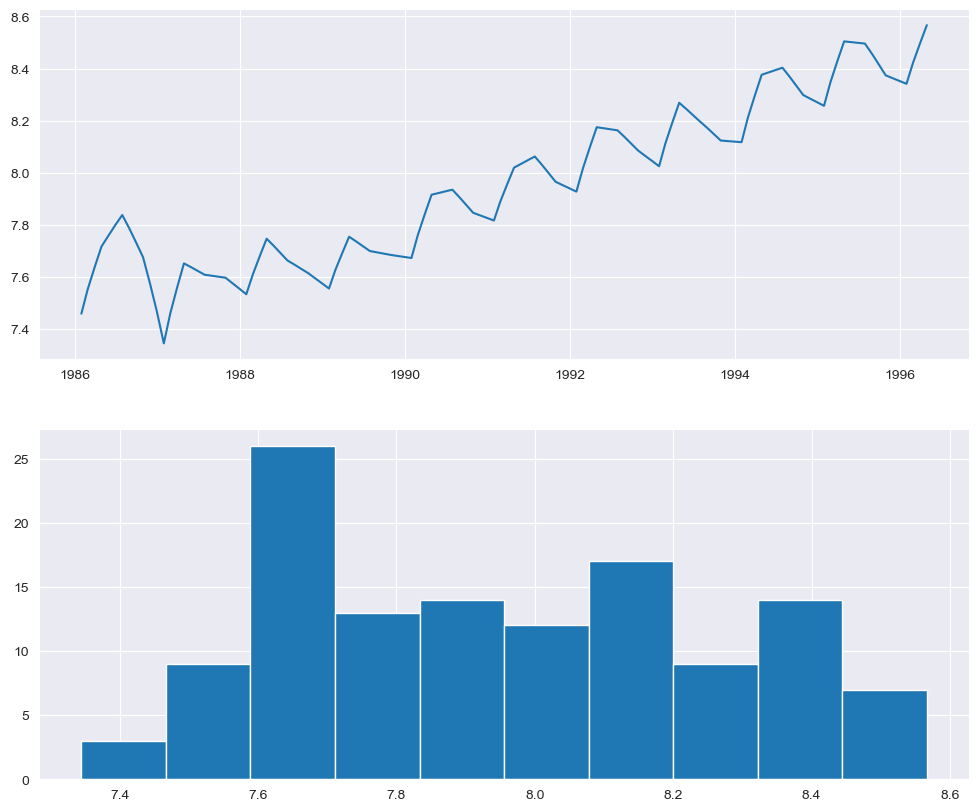

In [67]:
log = pd.DataFrame()
log = interpolated_month[['Sales']]
log['Sales'] = np.log(log.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Sales'])
#Histogram
plt.subplot(212)
plt.hist(log['Sales'])
plt.show()

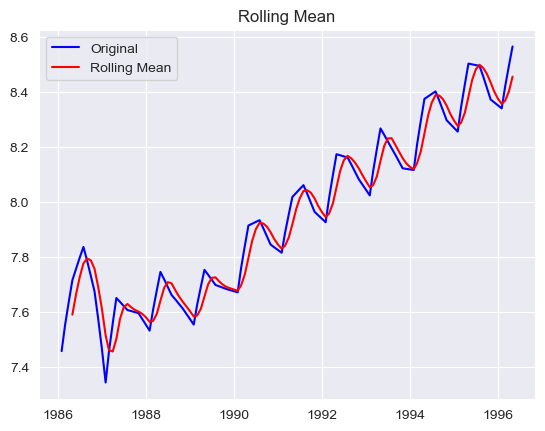

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [68]:
test_stationarity(log)

In [69]:
adf_test(log.Sales)

Fail to reject the null hypothesis
Data is non-stationary


#### Hence, the Time series data is Non-Stationary

### Converting Non-Stationary Time Series into Stationary

#### Box Cox Transformation

,Sales
Date,
1986-01-31,7.458663
1986-02-28,7.552170
1986-03-31,7.637676
1986-04-30,7.716443
1986-05-31,7.758437


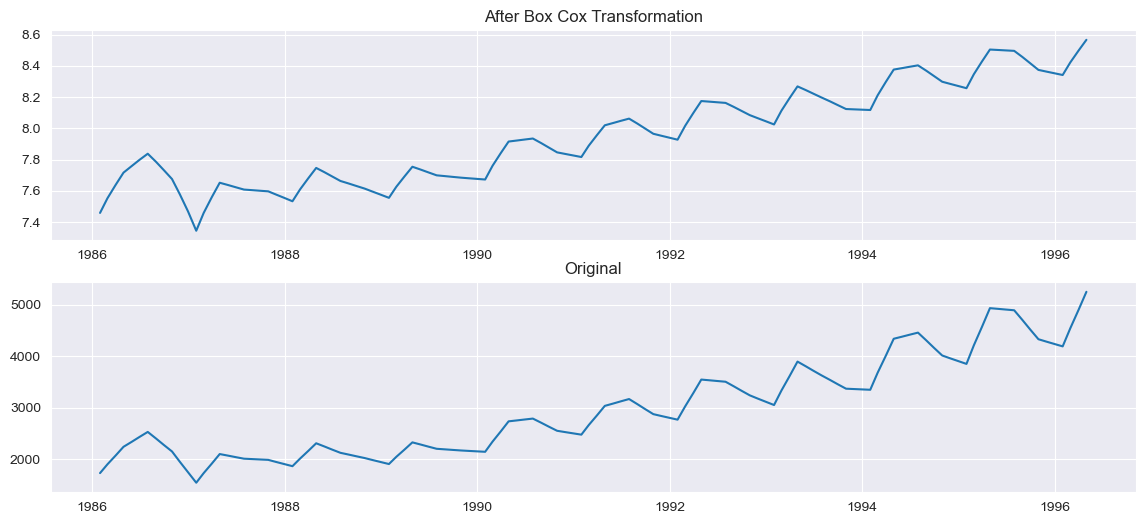

In [70]:
data_boxcox = pd.DataFrame()
data_boxcox['Sales'] = pd.Series(boxcox(interpolated_month['Sales'], lmbda=0), interpolated_month.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(interpolated_month, label='original')
axis[1].set_title('Original')
plt.show()

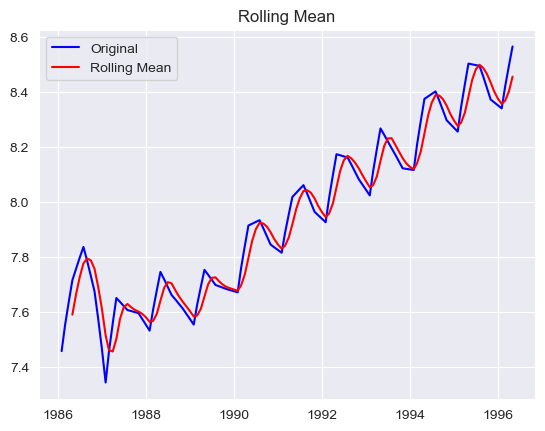

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [71]:
test_stationarity(data_boxcox)

In [72]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


#### Differencing of the Box-Cox Transformation

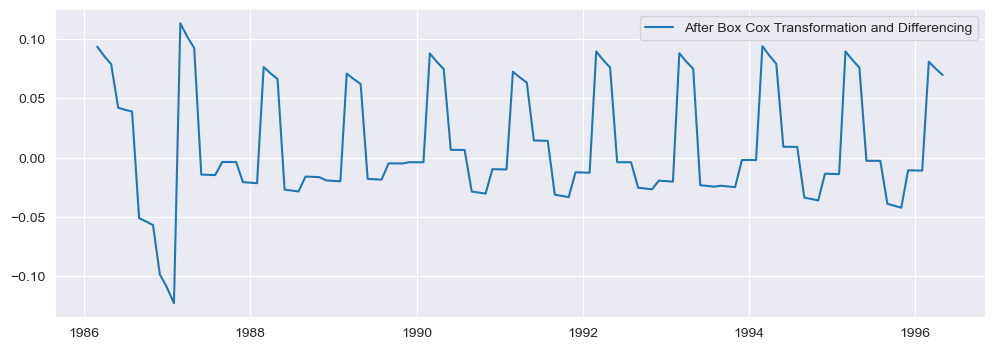

In [73]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

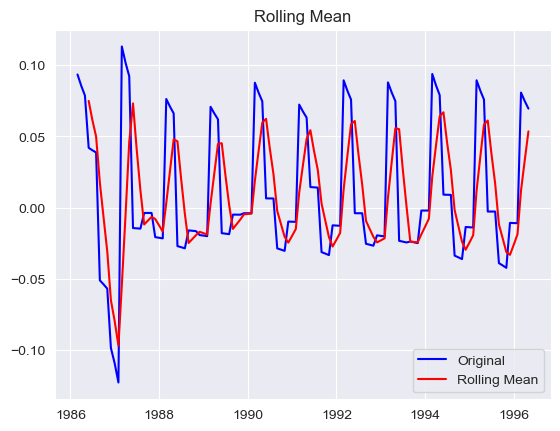

Results of Dickey Fuller Test:
Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [74]:
#check this log transfered data with function
test_stationarity(data_boxcox_diff)

In [75]:
adf_test(data_boxcox_diff.Sales)

Reject the null hypothesis
Data is stationary


#### Finally, Our Series is now stationary for AR Forecasting

#### ARIMA Hyperparameter Tuning

In [76]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [77]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [85]:
train_data_boxcox = data_boxcox[:100]
test_data_boxcox = data_boxcox[100:]
train_data_boxcox_diff = data_boxcox_diff[:99]
test_data_boxcox_diff = data_boxcox_diff[99:]

### Inverse transformation of the Box-Cox Differencing

In [80]:
model = ARIMA(train_data_boxcox_diff, order=(3, 0, 2))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['ar_forecast'] = y_hat_ar['ar_forecast'].add(data_boxcox.Sales[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast'])

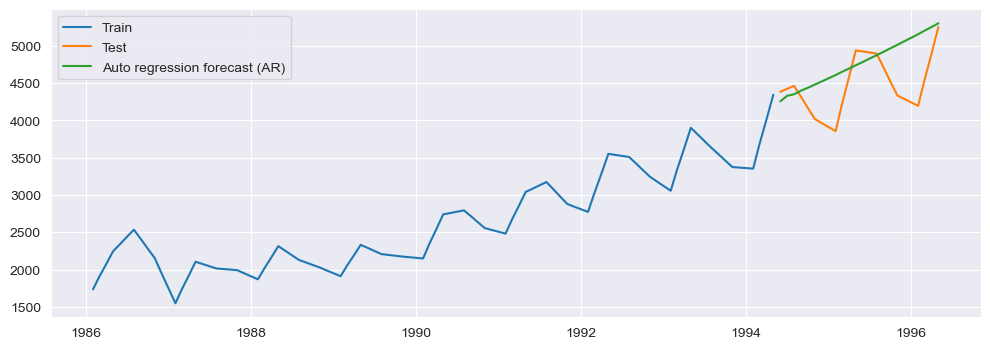

In [81]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['ar_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

### Model Evaluation

#### RMSE (Root Mean Squared Error)

In [82]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['ar_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

475.19

#### Analysing the Residuals

#### The mean of the Residual should be zero or close to Zero

In [86]:
model_residual = model_fit.resid
model_residual.mean()

0.00017901545114319922

#### Residuals must be stationary

In [87]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

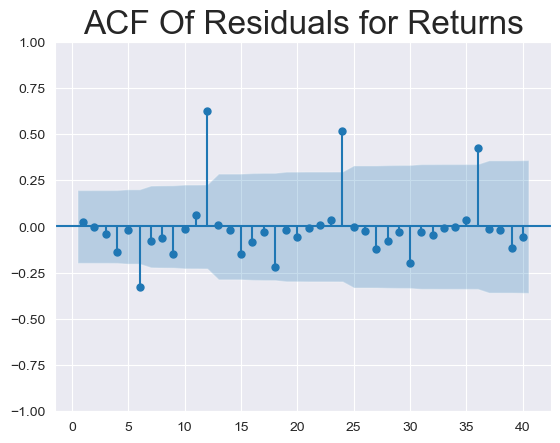

In [88]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

### Residuals must be random

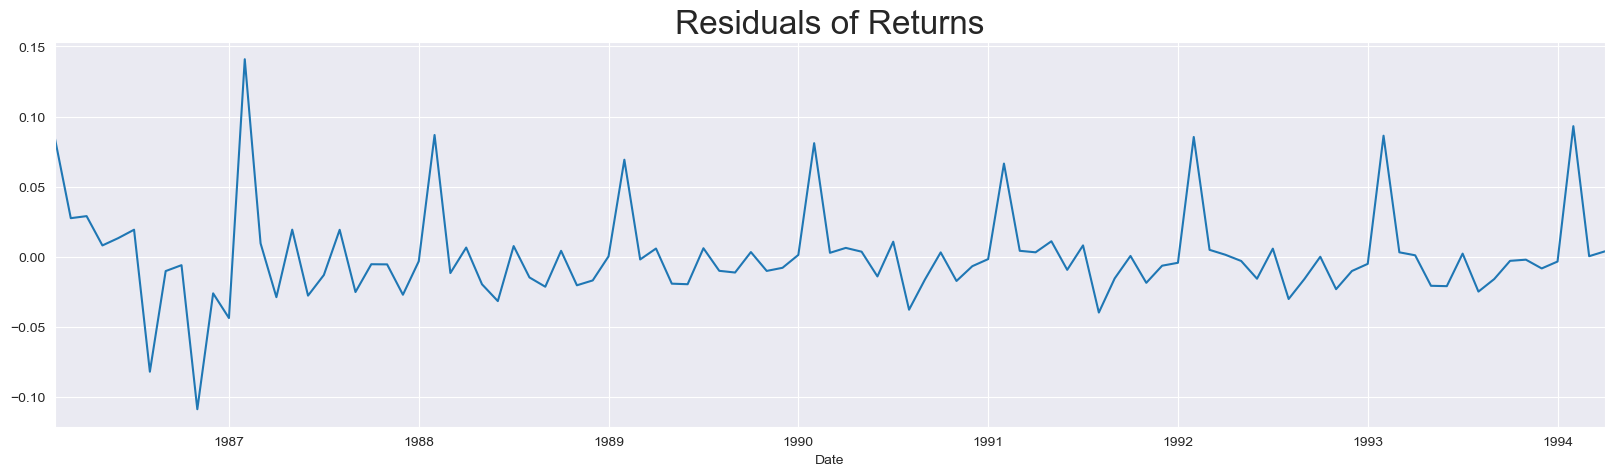

In [89]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

## Seasonal Auto Regressive Integrated Moving Average (SARIMA)¶

In [90]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [91]:
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

In [92]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

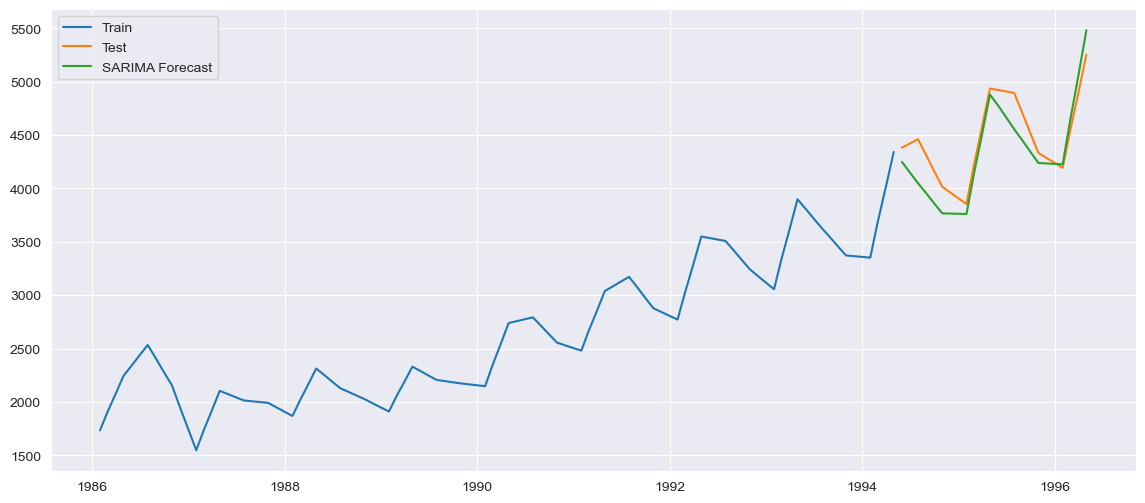

In [93]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

#### We can see that we are able to capture the trend and seasonality both.

## Model Evaluation

### RMSE (Root Mean Squared Error)

In [94]:
rmse_SARIMA = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_SARIMA

205.82

### Analysing the Residuals

### The mean of the Residual should be zero or close to Zero

In [96]:
model_residual = model_fit.resid
model_residual.mean()

0.03702159653502837

#### Residuals must be stationary

In [97]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


#### No autocorrelation between residuals

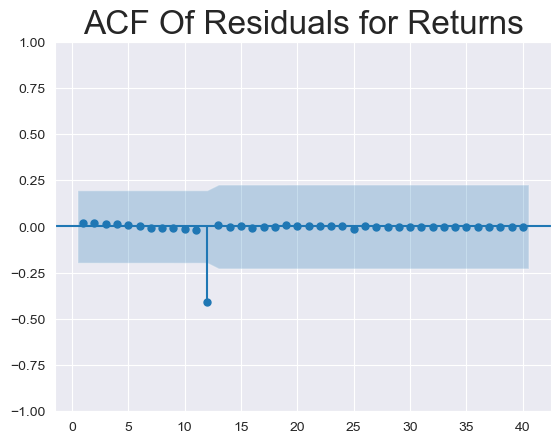

In [98]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

#### Residuals must be random

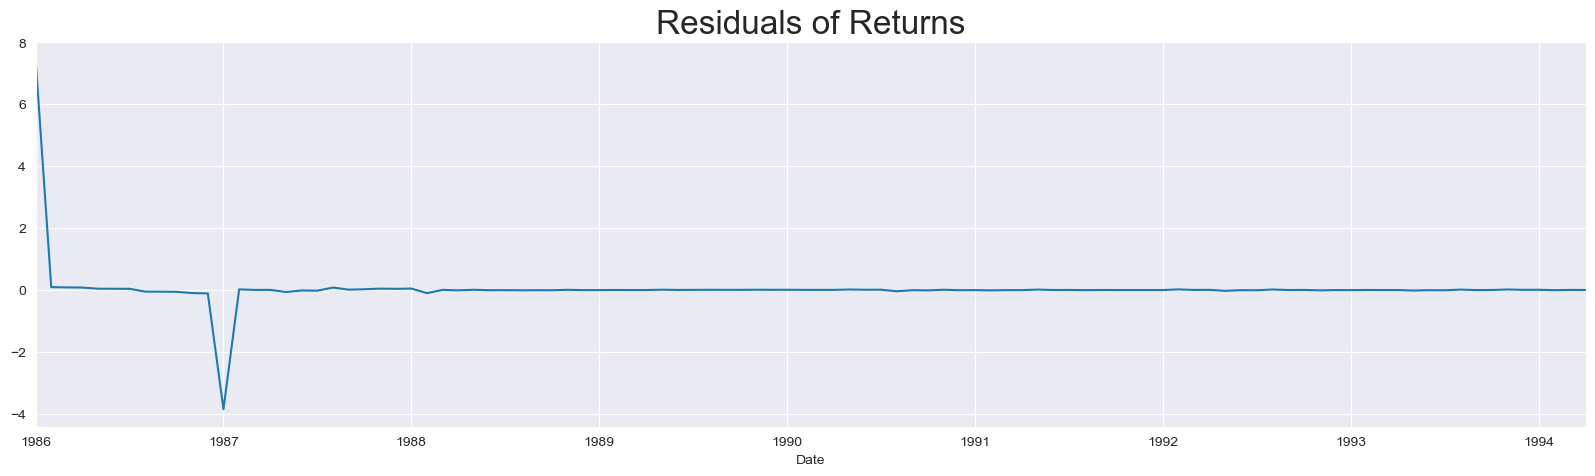

In [99]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()


### AFTER VARIOUS MODEL TESTING WE GET THE BEST MOEL SARIMA WITH LOW RMSE